In [1]:
import pandas as pd
import numpy as np
import cython 

from numba import jit

data = pd.read_csv('cleaned_dataset.csv')
data.head()

,Unnamed: 0,tavg,tmin,tmax,prcp,snow,wspd,pres,country,city
0,0,-3.0,-8.000000,1.000000,2.874871,5.813453,12.072765,1014.2371,Afghanistan,Kabul
1,1,-6.2,13.502185,23.347088,2.874871,5.813453,12.072765,1014.2371,Afghanistan,Kabul
2,2,-7.7,-14.000000,2.000000,2.874871,5.813453,12.072765,1014.2371,Afghanistan,Kabul
3,3,-8.4,-15.000000,-2.000000,2.874871,5.813453,12.072765,1014.2371,Afghanistan,Kabul
4,4,-7.8,-14.000000,23.347088,2.874871,5.813453,12.072765,1014.2371,Afghanistan,Kabul


Звичайний Python та його швидкодія:

In [2]:
def generating_func(previous_sum, s, x, k):
    if k == len(x):
        return previous_sum
    previous_sum += x.iloc[k] + s**k
    return previous_sum


result = 0
for j in range(int(len(data['tmin'])/1e4)):
    result += generating_func(result, 0.1, data['tmin'], j)

result

np.float64(-1.3641397316532902e+26)

In [3]:
%%timeit 
result = 0
for j in range(int(len(data['tmin'])/1e3)):
    result += generating_func(result, 0.1, data['tmin'], j)


10.9 ms ± 718 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Спробуємо Cython:

In [4]:
%load_ext Cython

In [5]:
%%cython
def  c_generating_func(previous_sum: cython.float, s: cython.float, x, k: cython.int) -> cython.double:
    if k == len(x):
        return previous_sum
    previous_sum += x.iloc[k] + s**k
    return previous_sum


In [6]:
%%timeit 
result = 0
for j in range(int(len(data['tmin'])/1e4)):
    result += c_generating_func(result, 0.1, data['tmin'], j)

result

1.99 ms ± 968 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Спробуємо Numba:

In [7]:
@jit
def generating_func(previous_sum, s, x, k):
    if k == len(x):
        return previous_sum
    previous_sum += x[k] + s**k
    return previous_sum

In [8]:
%%timeit 
result = 0
for j in range(int(len(data['tmin'])/1e4)):
    result += generating_func(result, 0.1, np.array(data['tmin'].values), j)

result

261 ms ± 61.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Формула Блека-Скоулза, туторіал:

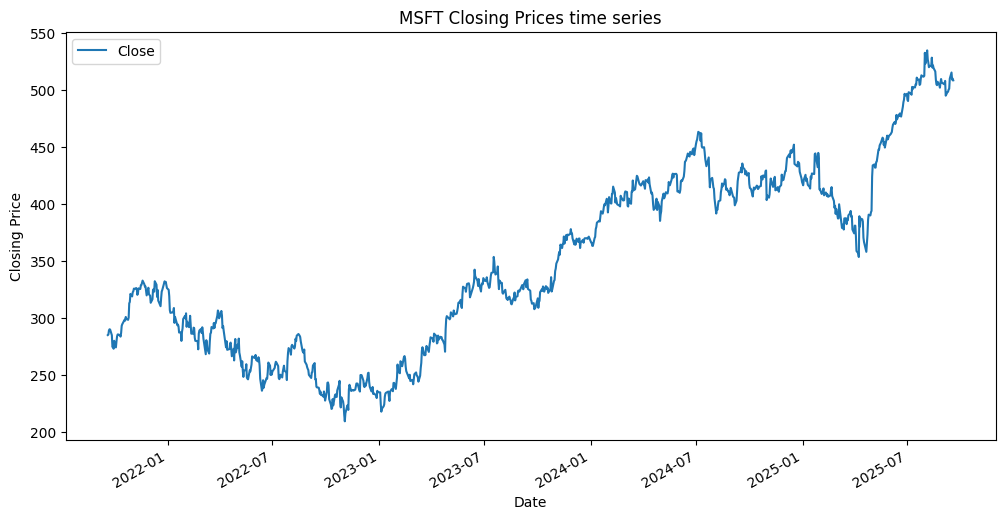

In [9]:
# Import yfinance library and pyplot module from matplotlib
import yfinance as yf
import matplotlib.pyplot as plt

import datetime
from datetime import timedelta

# Netflix
stock = 'MSFT'
ticker = yf.Ticker(stock)
today = datetime.date.today()

stock_data = ticker.history(
    interval='1d', 
    start=today-timedelta(days=4*365), 
    end=today
    )

# Plotting the closing price `Close` over the last 4 years
stock_data.plot(y='Close', figsize=(12,6))
plt.title(f'{stock} Closing Prices time series')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

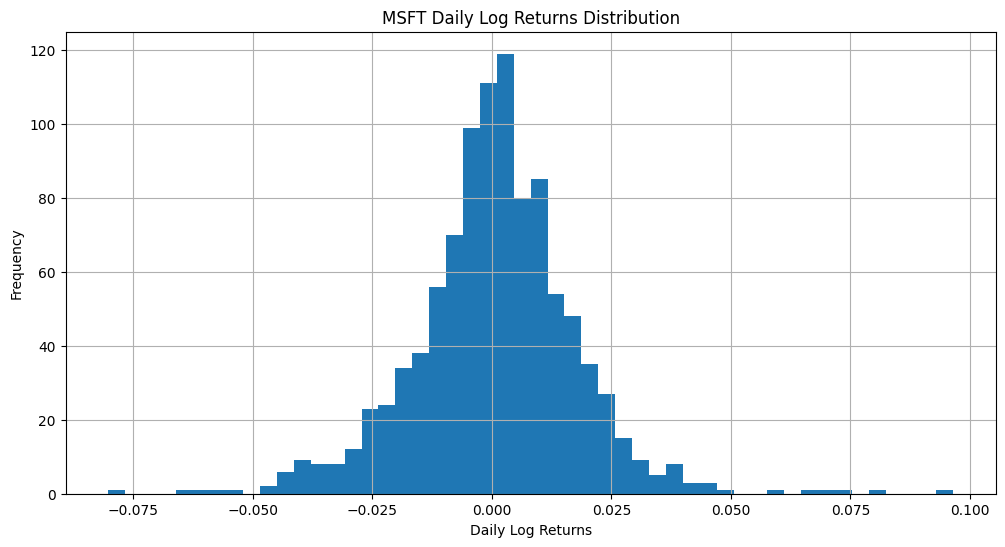

In [10]:
# Returns distributions
daily_returns = stock_data['Close'].pct_change()

# log returns distributions
daily_log_returns = np.log(daily_returns+1)

# Plotting histogram of the log-returns
daily_log_returns.hist(bins=50, figsize=(12,6))
plt.title(f'{stock} Daily Log Returns Distribution')
plt.xlabel('Daily Log Returns')
plt.ylabel('Frequency')
plt.show()

In [11]:
volatility = np.std(daily_log_returns)*np.sqrt(252)
print(f"The annualised volatility of {stock} is {volatility}")

The annualised volatility of MSFT is 0.26956269778831177


In [12]:
# get all option expirey date
expirations = ticker.options

# Selecting element 7 as the expiry date i.e. 2025-01-17
# list options with a chosen expirey
expiry = expirations[0]

options = ticker.option_chain(date = expiry)

# Get the option with index 2
option = options.calls.iloc[2] 
purchase_date = option.lastTradeDate # Date the Contract was priced
time_to_maturity = pd.Timestamp(expiry + ' 16:00:00', tz='EST') - purchase_date.tz_convert('EST') # The number of days to maturity

In [13]:
# stock price when option was traded
minute_data = ticker.history(
    interval='1m', 
    start=purchase_date-timedelta(minutes=1), 
    end=purchase_date+timedelta(minutes=5)
    )

# Price of the stock
stock_price = minute_data.iloc[1].Close

print(f'Current stock price: {stock_price:.2f}')

Current stock price: 494.86


In [14]:
# Creating a ticker for `^IRX`
treasury_3m = yf.Ticker('^IRX')

# Risk Free Rate on date the option was purchased (on `purchase_date`)
minute_history_bond = treasury_3m.history(
    interval='1m', 
    start=purchase_date-timedelta(minutes=1), 
    end=purchase_date+timedelta(minutes=5)
    )

# Risk free rate
usbond = minute_history_bond.iloc[0].Close

print(f'Risk Free Rate: {usbond:.2f}%')

Risk Free Rate: 3.91%


In [15]:
from scipy.stats import norm

# Black-Scholes Formula
def BlackScholes(S, K, T, r, sigma):
    d1 = ((r + 0.5*sigma**2)*T + np.log(S/K))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    C = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return C


In [16]:
%%timeit
# Fair price of the call option
Call = BlackScholes(
    stock_price, 
    option.strike, 
    time_to_maturity.days/365, 
    usbond/100, 
    volatility
    )
Call

240 μs ± 3.97 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
def C_BlackScholes(S: cython.float, K: cython.float, T: cython.float, r: cython.float, sigma: cython.float) -> cython.float:
    d1: cython.float = ((r + 0.5*sigma**2)*T + np.log(S/K))/(sigma*np.sqrt(T))
    d2: cython.float = d1 - sigma*np.sqrt(T)
    C: cython.float = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return C

In [18]:
%%timeit
# Fair price of the call option
Call = C_BlackScholes(
    stock_price, 
    option.strike, 
    time_to_maturity.days/365, 
    usbond/100, 
    volatility
    )
Call

279 μs ± 53.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:
@jit
def erf_approx(x):
    """Numerical approximation of erf(x) using Abramowitz & Stegun 7.1.26"""
    # constants
    a1, a2, a3, a4, a5 = 0.254829592, -0.284496736, 1.421413741, -1.453152027, 1.061405429
    p = 0.3275911

    sign = np.sign(x)
    x = np.abs(x)

    t = 1.0 / (1.0 + p * x)
    y = 1.0 - (((((a5 * t + a4) * t) + a3) * t + a2) * t + a1) * t * np.exp(-x * x)

    return sign * y

@jit
def normal_cdf(x, mu=0.0, sigma=1.0):
    """Normal CDF using erf approximation (NumPy-only)."""
    z = (x - mu) / (sigma * np.sqrt(2))
    return 0.5 * (1.0 + erf_approx(z))

@jit
def jit_BlackScholes(S, K, T, r, sigma):
    d1 = ((r + 0.5*sigma**2)*T + np.log(S/K))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    C = S*np.array([normal_cdf(d1)]) - K*np.exp(-r*T)*np.array([normal_cdf(d2)])
    return C


In [20]:
%%timeit
Call = jit_BlackScholes(
    stock_price, 
    option.strike, 
    time_to_maturity.days/365, 
    usbond/100, 
    volatility
    )

The slowest run took 8.84 times longer than the fastest. This could mean that an intermediate result is being cached.
24.2 μs ± 27.8 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
